In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt     
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.signal import periodogram

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import joblib
import shap


Importing data¶


In [3]:
train_df = pd.read_csv("train.csv", parse_dates=["date"])
test_df = pd.read_csv("test.csv", parse_dates=["date"])
store_df = pd.read_csv("stores.csv")
oil_df = pd.read_csv("oil.csv", parse_dates=["date"])
transaction_df = pd.read_csv("transactions.csv ", parse_dates=["date"])
holiday_events_df = pd.read_csv("holidays_events.csv", parse_dates=["date"])
sample_submission_df = pd.read_csv("sample_submission.csv")



EDA¶



First few rows of each dataframe¶


In [3]:
print("\nSample Submission DataFrame:")
sample_submission_df.head()


Sample Submission DataFrame:


,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


In [4]:
print("Train DataFrame:")
train_df.tail()                     

Train DataFrame:


,id,date,store_nbr,family,sales,onpromotion
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0


In [5]:
print("\nTest DataFrame:")
test_df.tail()


Test DataFrame:


,id,date,store_nbr,family,onpromotion
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9
28511,3029399,2017-08-31,9,SEAFOOD,0


In [6]:
print("\nStores DataFrame:")
store_df.tail()


Stores DataFrame:


,store_nbr,city,state,type,cluster
49,50,Ambato,Tungurahua,A,14
50,51,Guayaquil,Guayas,A,17
51,52,Manta,Manabi,A,11
52,53,Manta,Manabi,D,13
53,54,El Carmen,Manabi,C,3


In [7]:
print("\nOil DataFrame:")
oil_df.tail()



Oil DataFrame:


,date,dcoilwtico
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96
1217,2017-08-31,47.26


In [8]:
print("\nTransactions DataFrame:")
transaction_df.tail()


Transactions DataFrame:


,date,store_nbr,transactions
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932
83487,2017-08-15,54,802


In [9]:
print("\nHoliday Events DataFrame:")
holiday_events_df.head()


Holiday Events DataFrame:


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [10]:
train_df.describe()

,id,date,store_nbr,sales,onpromotion
count,3.000888e+06,3000888,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2015-04-24 08:27:04.703088384,2.750000e+01,3.577757e+02,2.602770e+00
min,0.000000e+00,2013-01-01 00:00:00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,2014-02-26 18:00:00,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2015-04-24 12:00:00,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,2016-06-19 06:00:00,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,2017-08-15 00:00:00,5.400000e+01,1.247170e+05,7.410000e+02
std,8.662819e+05,NaN,1.558579e+01,1.101998e+03,1.221888e+01


In [4]:
train_df = pd.merge(train_df, store_df, on="store_nbr", how="left", suffixes=("_train", "_store"))
train_df = pd.merge(train_df, oil_df, on="date", how="left", suffixes=("_train", "_oil"))
train_df = pd.merge(train_df, transaction_df, on=["date", "store_nbr"], how="left", suffixes=("_train", "_transaction"))
train_df = pd.merge(train_df, holiday_events_df, on="date", how="left", suffixes=("_train", "_holiday"))

In [5]:
train_df.isnull().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
city                  0
state                 0
type_train            0
cluster               0
dcoilwtico       955152
transactions     249117
type_holiday    2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
dtype: int64

In [6]:
train_df['dcoilwtico'] = train_df['dcoilwtico'].fillna(method='ffill')
train_df['dcoilwtico'] = train_df['dcoilwtico'].fillna(method='bfill')

C:\Users\M Khubaib Ahmad\AppData\Local\Temp\ipykernel_16280\2431101907.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_df['dcoilwtico'] = train_df['dcoilwtico'].fillna(method='ffill')
C:\Users\M Khubaib Ahmad\AppData\Local\Temp\ipykernel_16280\2431101907.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_df['dcoilwtico'] = train_df['dcoilwtico'].fillna(method='bfill')


In [7]:
train_df['transactions'] = train_df['transactions'].fillna(method='ffill')
train_df['transactions'] = train_df['transactions'].fillna(0)

C:\Users\M Khubaib Ahmad\AppData\Local\Temp\ipykernel_16280\756027591.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_df['transactions'] = train_df['transactions'].fillna(method='ffill')


In [8]:
train_df[['type_holiday', 'locale', 'locale_name', 'description']] = train_df[['type_holiday', 'locale', 'locale_name', 'description']].fillna('No Holiday')

In [9]:
train_df['transferred'].fillna(False, inplace=True)

C:\Users\M Khubaib Ahmad\AppData\Local\Temp\ipykernel_16280\217341058.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['transferred'].fillna(False, inplace=True)
C:\Users\M Khubaib Ahmad\AppData\Local\Temp\ipykernel_16280\217341058.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['transf

In [10]:
train_df.isnull().sum()

id              0
date            0
store_nbr       0
family          0
sales           0
onpromotion     0
city            0
state           0
type_train      0
cluster         0
dcoilwtico      0
transactions    0
type_holiday    0
locale          0
locale_name     0
description     0
transferred     0
dtype: int64

In [18]:
train_df.describe()

,id,date,store_nbr,sales,onpromotion,cluster,dcoilwtico,transactions
count,3.054348e+06,3054348,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06
mean,1.504277e+06,2015-04-26 12:11:45.717619200,2.750000e+01,3.590209e+02,2.617480e+00,8.481481e+00,6.785992e+01,1.689279e+03
min,0.000000e+00,2013-01-01 00:00:00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.619000e+01,0.000000e+00
25%,7.546768e+05,2014-03-01 00:00:00,1.400000e+01,0.000000e+00,0.000000e+00,4.000000e+00,4.632000e+01,1.055000e+03
50%,1.507572e+06,2015-04-28 12:00:00,2.750000e+01,1.100000e+01,0.000000e+00,8.500000e+00,5.341000e+01,1.419000e+03
75%,2.255120e+06,2016-06-22 00:00:00,4.100000e+01,1.960110e+02,0.000000e+00,1.300000e+01,9.572000e+01,2.034000e+03
max,3.000887e+06,2017-08-15 00:00:00,5.400000e+01,1.247170e+05,7.410000e+02,1.700000e+01,1.106200e+02,8.359000e+03
std,8.662610e+05,NaN,1.558579e+01,1.107286e+03,1.225494e+01,4.649735e+00,2.566330e+01,9.385459e+02


In [19]:
train_df.head(3)

,id,date,store_nbr,family,sales,onpromotion,city,state,type_train,cluster,dcoilwtico,transactions,type_holiday,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Holiday,National,Ecuador,Primer dia del ano,False



Date Range¶


In [11]:
min_date = train_df['date'].min()
max_date = train_df['date'].max() 

print(f"Date range of the dataset: From {min_date.strftime('%Y-%m-%d')} to {max_date.strftime('%Y-%m-%d')}")

Date range of the dataset: From 2013-01-01 to 2017-08-15


In [12]:
full_range = pd.date_range(start = min_date, end = max_date, freq='D')
full_range.isnull().sum()

np.int64(0)


Feature Engineering¶


In [13]:
train_df['day_of_week'] = train_df['date'].dt.dayofweek

In [14]:
train_df['day'] = train_df['date'].dt.day
train_df['month'] = train_df['date'].dt.month
train_df['year'] = train_df['date'].dt.year

In [15]:
train_df['sales_lag_1'] = train_df.groupby(['store_nbr', 'family'])['sales'].shift(1) #previous day sale 
train_df['sales_rolling_7'] = train_df.groupby(['store_nbr', 'family'])['sales'].shift(1).rolling(7).mean()
# average sale of previous week sales

In [28]:
train_df['sales_lag_1'] = train_df['sales_lag_1'].fillna(0)
train_df['sales_rolling_7'] = train_df['sales_rolling_7'].fillna(0)


Sales distribution¶


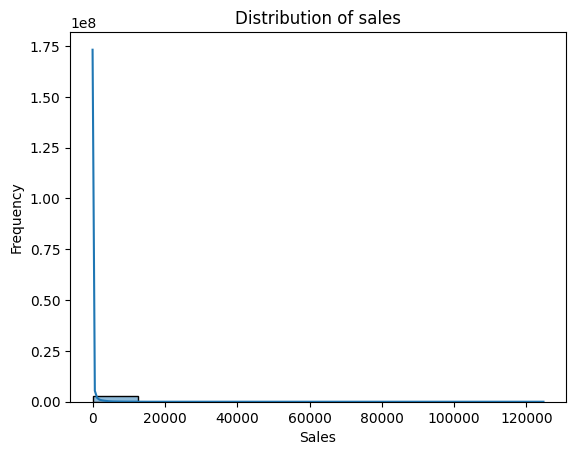

In [25]:
sns.histplot(train_df['sales'], bins=10, kde=True)
plt.title('Distribution of sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

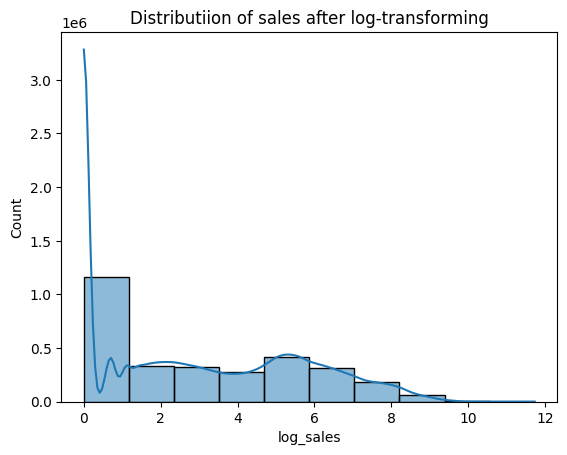

In [26]:
train_df['log_sales'] = np.log1p(train_df['sales'])
sns.histplot(train_df['log_sales'], bins=10, kde=True)  
plt.title("Distributiion of sales after log-transforming")
plt.show() 


Detecting outliers in sales by IQR¶


In [16]:
Q1 = train_df['sales'].quantile(0.25)
Q3 = train_df['sales'].quantile(0.75)

IQR = Q3 - Q1

lower_bound_iqr = Q1 - 1.5 * IQR
upper_bound_iqr = Q3 + 1.5 * IQR

print(f"Q1 (25th percentile): {Q1}")
print(f"Q3 (75th percentile): {Q3}")
print(f"IQR: {IQR}")
print(f"Lower bound (IQR): {lower_bound_iqr}")
print(f"Upper bound (IQR): {upper_bound_iqr}")

# Identify outliers based on IQR
iqr_outliers = train_df[(train_df['sales'] < lower_bound_iqr) | (train_df['sales'] > upper_bound_iqr)]

print("\nOutliers using IQR method:")
if not iqr_outliers.empty:
    print(iqr_outliers)
else:
    print("No outliers detected using IQR method.")

Q1 (25th percentile): 0.0
Q3 (75th percentile): 196.011
IQR: 196.011
Lower bound (IQR): -294.0165
Upper bound (IQR): 490.02750000000003

Outliers using IQR method:
              id       date  store_nbr         family     sales  onpromotion  \
564          564 2013-01-01         25      BEVERAGES   810.000            0   
573          573 2013-01-01         25      GROCERY I   700.000            0   
1785        1785 2013-01-02          1      BEVERAGES  1091.000            0   
1789        1789 2013-01-02          1       CLEANING  1060.000            0   
1790        1790 2013-01-02          1          DAIRY   579.000            0   
...          ...        ...        ...            ...       ...          ...   
3054323  3000863 2017-08-15          9          DAIRY   835.000           19   
3054324  3000864 2017-08-15          9           DELI   551.713            7   
3054327  3000867 2017-08-15          9      GROCERY I  6630.383           62   
3054340  3000880 2017-08-15         

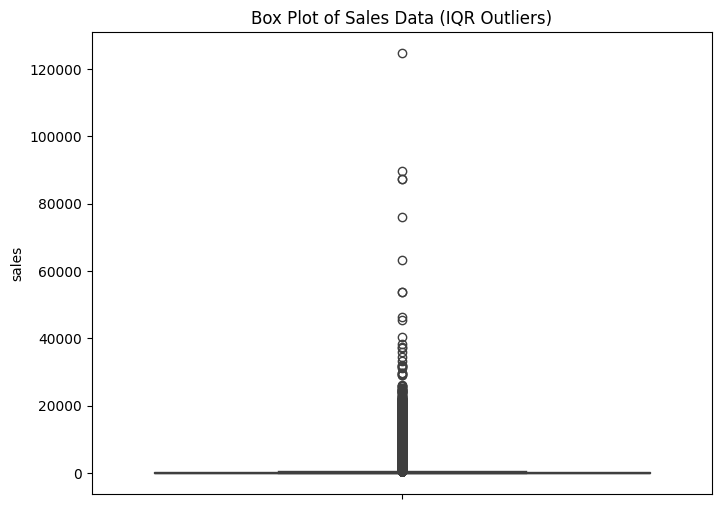

In [28]:
plt.figure(figsize=(8, 6))
sns.boxplot(y=train_df['sales'])
plt.title('Box Plot of Sales Data (IQR Outliers)')
plt.ylabel('sales')
plt.show()


Outliers detection by Z-Score¶


In [17]:
mean_sales = train_df['sales'].mean()
std_sales = train_df['sales'].std()

train_df['Z_Score'] = (train_df['sales'] - mean_sales) / std_sales

z_score_threshold = 3

print(f"Mean Sales: {mean_sales:.2f}")
print(f"Standard Deviation Sales: {std_sales:.2f}")
print(f"Z-score threshold: +/- {z_score_threshold}")

z_score_outliers = train_df[(train_df['Z_Score'].abs() > z_score_threshold)]
print("\nOutliers using Z-score method:")


if not z_score_outliers.empty:
    print(z_score_outliers)
else:
    print("No outliers detected using Z-score method.")

Mean Sales: 359.02
Standard Deviation Sales: 1107.29
Z-score threshold: +/- 3

Outliers using Z-score method:
              id       date  store_nbr     family     sales  onpromotion  \
1860        1860 2013-01-02         11  GROCERY I  7736.000            0   
2091        2091 2013-01-02         18  GROCERY I  3756.000            0   
2157        2157 2013-01-02          2  GROCERY I  3870.000            0   
2322        2322 2013-01-02         24  GROCERY I  3920.000            0   
2511        2511 2013-01-02          3  BEVERAGES  4486.000            0   
...          ...        ...        ...        ...       ...          ...   
3054252  3000792 2017-08-15          7  BEVERAGES  3999.000            9   
3054279  3000819 2017-08-15          7    PRODUCE  5113.961            6   
3054294  3000834 2017-08-15          8  GROCERY I  4035.000           34   
3054312  3000852 2017-08-15          8    PRODUCE  3939.392           10   
3054327  3000867 2017-08-15          9  GROCERY I  663

c:\Users\M Khubaib Ahmad\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


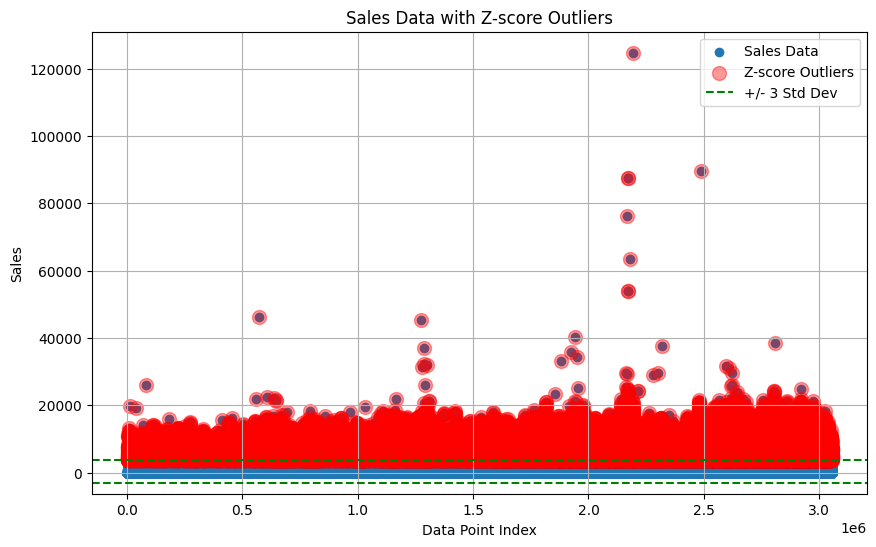

In [30]:
plt.figure(figsize=(10, 6))
plt.scatter(train_df.index, train_df['sales'], label='Sales Data')
plt.scatter(z_score_outliers.index, z_score_outliers['sales'], color='red', marker='o', s=100, label='Z-score Outliers', alpha=0.4)
plt.axhline(mean_sales + z_score_threshold * std_sales, color='green', linestyle='--', label=f'+/- {z_score_threshold} Std Dev')
plt.axhline(mean_sales - z_score_threshold * std_sales, color='green', linestyle='--')
plt.title('Sales Data with Z-score Outliers')
plt.xlabel('Data Point Index')      
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


Sales by store Number¶


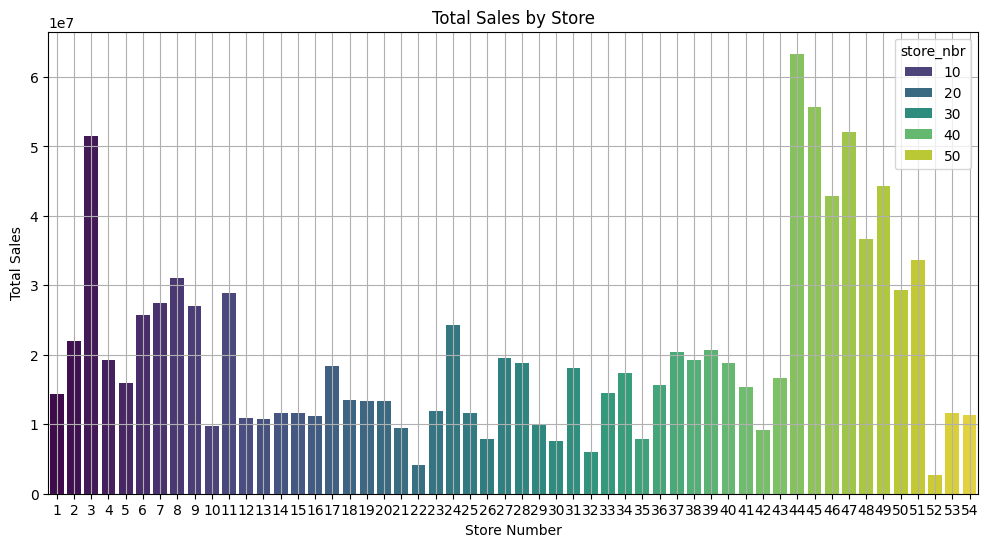

In [31]:
sales_by_store = train_df.groupby('store_nbr')['sales'].sum()
plt.figure(figsize=(12, 6))
sns.barplot(x=sales_by_store.index, y=sales_by_store.values, palette = 'viridis', hue = sales_by_store.index)
plt.title('Total Sales by Store')
plt.xlabel('Store Number')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()


Total sales by locale¶


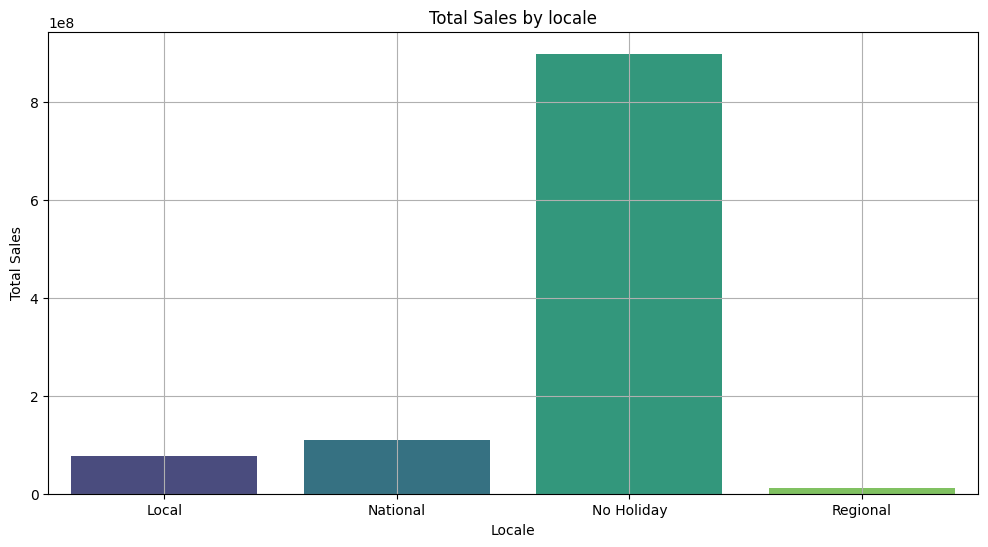

In [ ]:
sales_by_locale = train_df.groupby('locale')['sales'].sum()
plt.figure(figsize=(12, 6))
sns.barplot(x=sales_by_locale.index, y=sales_by_locale.values, palette = 'viridis', hue = sales_by_locale.index)
plt.title('Total Sales by locale')
plt.xlabel('Locale')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()


Total sales by type of holiday¶


In [29]:
n = 10
max_des = train_df['description'].value_counts().nlargest(n).index
max_des

Index(['No Holiday', 'Carnaval', 'Fundacion de Cuenca', 'Primer dia del ano',
       'Provincializacion de Cotopaxi', 'Fundacion de Manta',
       'Cantonizacion de Cayambe', 'Fundacion de Guayaquil-1',
       'Cantonizacion de Libertad', 'Cantonizacion de Riobamba'],
      dtype='object', name='description')

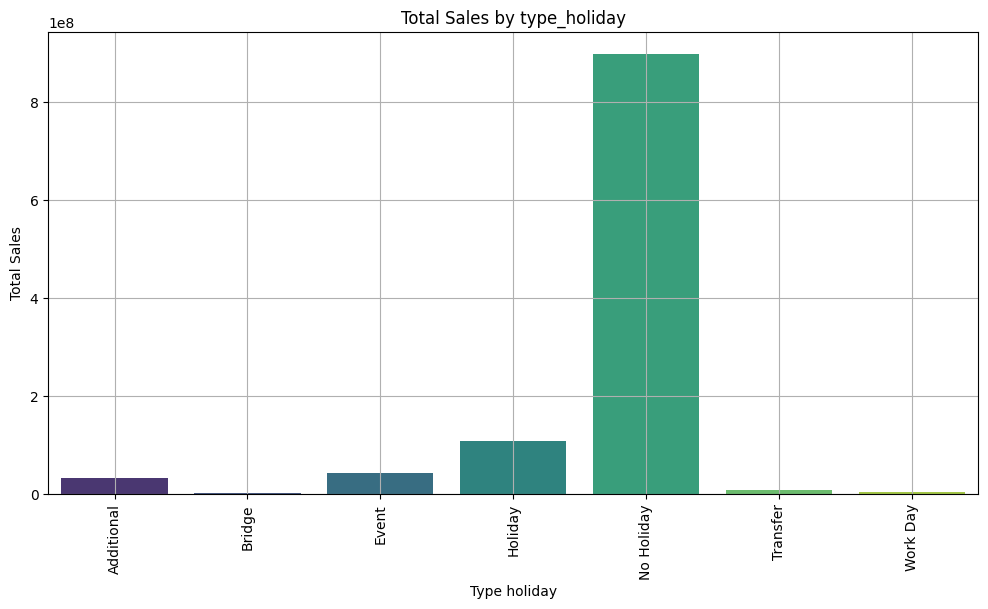

In [34]:
sales_by_type_holiday = train_df.groupby('type_holiday')['sales'].sum()
plt.figure(figsize=(12, 6))
sns.barplot(x=sales_by_type_holiday.index, y=sales_by_type_holiday.values, palette = 'viridis', hue = sales_by_type_holiday.index)
plt.title('Total Sales by type_holiday')
plt.xlabel('Type holiday')
plt.ylabel('Total Sales')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


Impact of promotion on sales¶


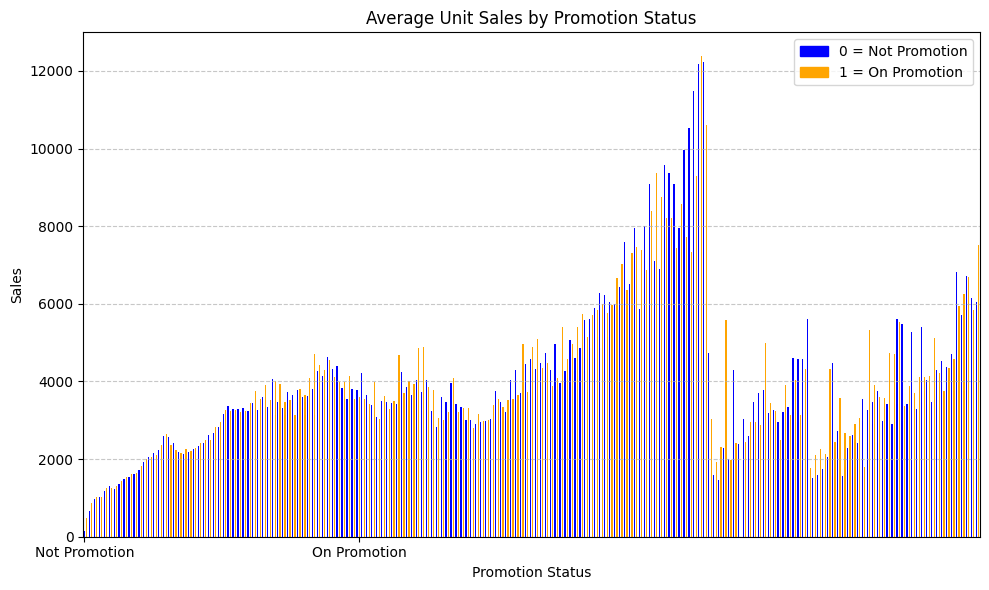

In [35]:
promo_sales = train_df.groupby('onpromotion')['sales'].mean()
promo_sales.plot(kind='bar', figsize=(10, 6), color=['blue', 'orange'])

# Title and axis labels
plt.title('Average Unit Sales by Promotion Status')
plt.xlabel("Promotion Status")
plt.ylabel("Sales")

# Custom x-axis labels
plt.xticks([0, 111], ['Not Promotion', 'On Promotion'], rotation=0)

# Custom legend using Patch
legend_labels = [
    mpatches.Patch(color='blue', label='0 = Not Promotion'),
    mpatches.Patch(color='orange', label='1 = On Promotion')
]
plt.legend(handles=legend_labels)

# Grid and layout
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



Holiday type vs Sales¶


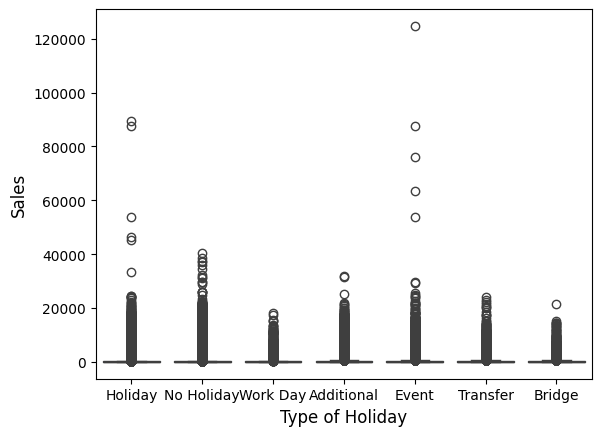

In [36]:
sns.boxplot(data=train_df, x='type_holiday', y='sales')
plt.xlabel('Type of Holiday', fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.show()


oil prices vs sales¶


c:\Users\M Khubaib Ahmad\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


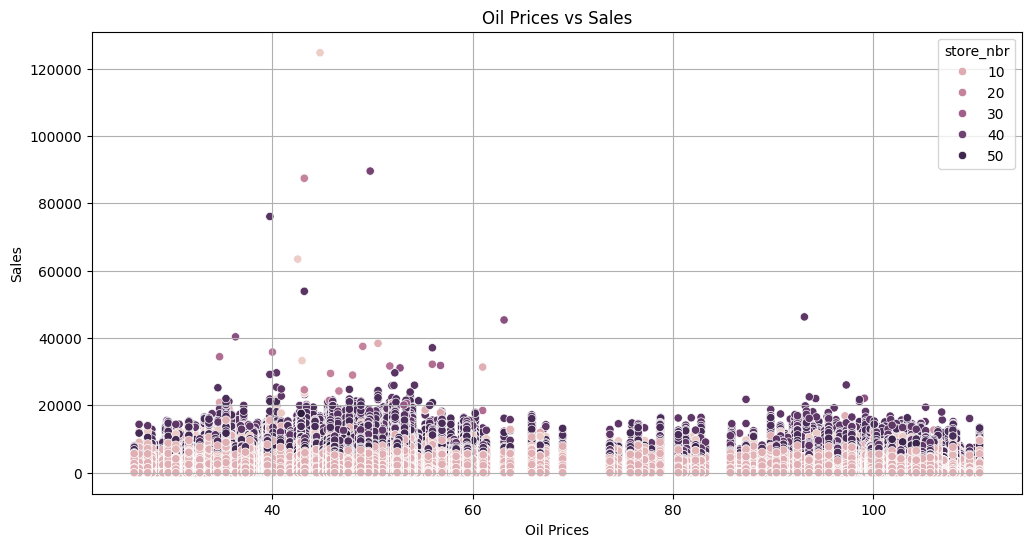

In [37]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='dcoilwtico', y='sales', data=train_df, hue = 'store_nbr')
plt.grid(True)
plt.title('Oil Prices vs Sales')
plt.xlabel('Oil Prices')
plt.ylabel('Sales')
plt.show()


Transactionns vs sales¶


<Axes: xlabel='transactions', ylabel='sales'>

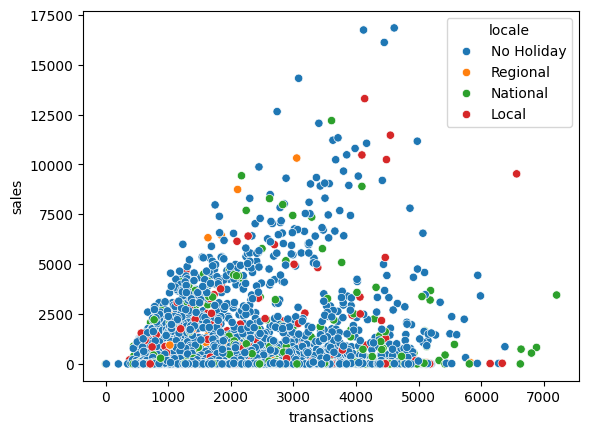

In [38]:
sns.scatterplot(x='transactions', y='sales',hue = 'locale' ,data=train_df.sample(10000))



Univariate Analysis¶



Sales trend in week¶


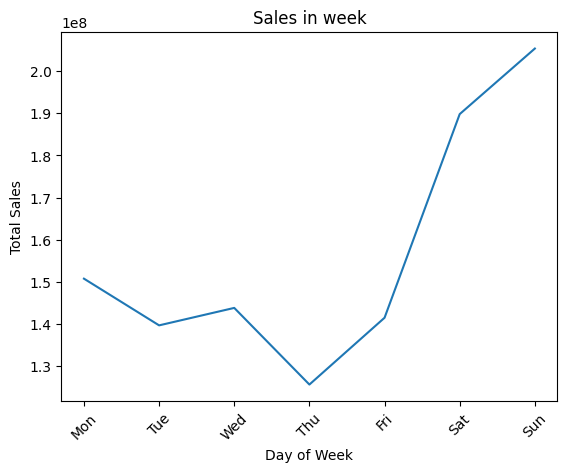

In [39]:
week_sales = train_df.groupby('day_of_week')['sales'].sum()
sns.lineplot( x=week_sales.index, y=week_sales.values)
plt.xlabel("Day of Week")
plt.ylabel("Total Sales")
plt.xticks(ticks=week_sales.index, labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=45)
plt.title("Sales in week")
plt.show()


Sales trend in month¶


<Axes: title={'center': 'Sales trend by days of the month'}, xlabel='day'>

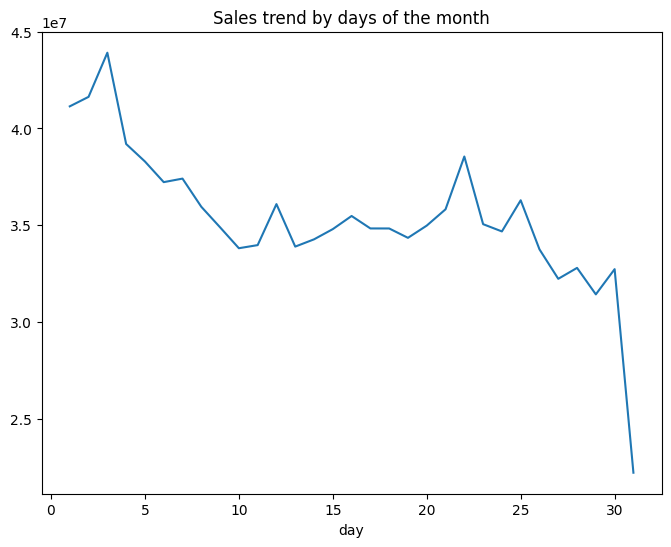

In [40]:
monthly_sales = train_df.groupby('day')['sales'].sum()
monthly_sales.plot(figsize=(8, 6), title='Sales trend by days of the month')


Monthly Sales Analysis¶


<Axes: title={'center': 'Sales trend by months'}, xlabel='month'>

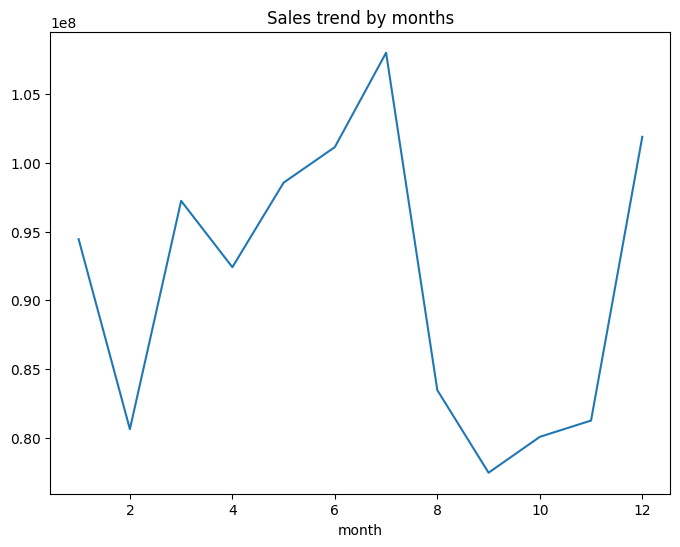

In [41]:
month_by_Month_sales = train_df.groupby('month')['sales'].sum()
month_by_Month_sales.plot(figsize=(8, 6), title='Sales trend by months')

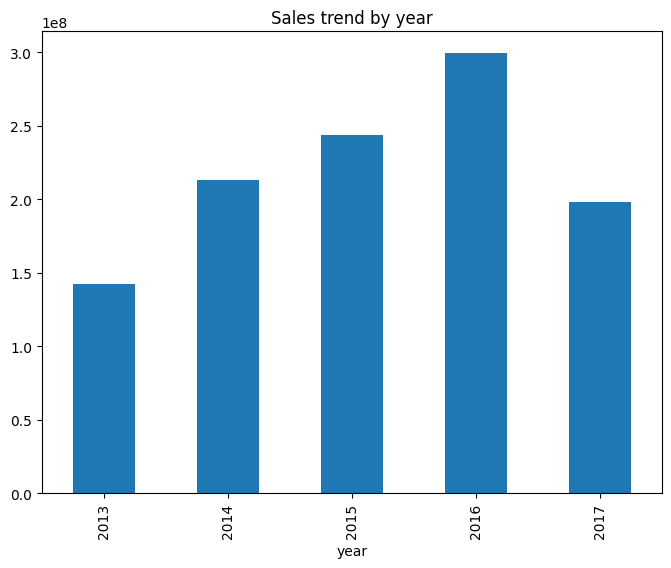

In [42]:
daily_sales = train_df.groupby('year')['sales'].sum()
daily_sales.plot(figsize=(8,6), title='Sales trend by year')
daily_sales.plot(kind = 'bar')
plt.show()

<Axes: ylabel='transactions'>

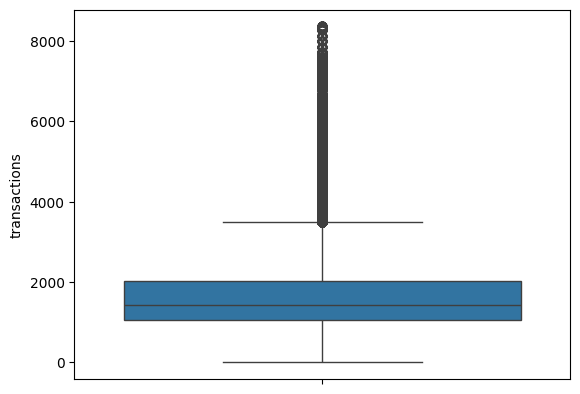

In [43]:
sns.boxplot(train_df['transactions'])

<Axes: ylabel='sales'>

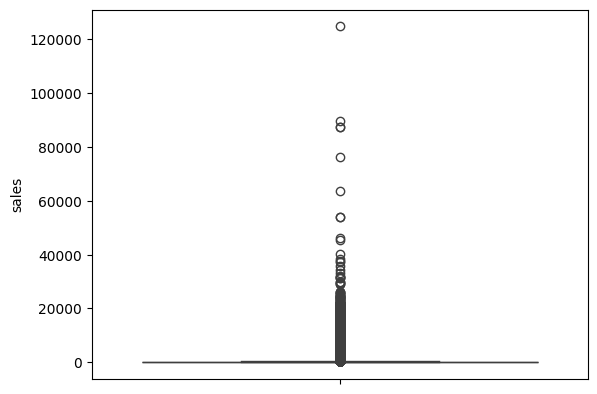

In [44]:
sns.boxplot(train_df['sales'])

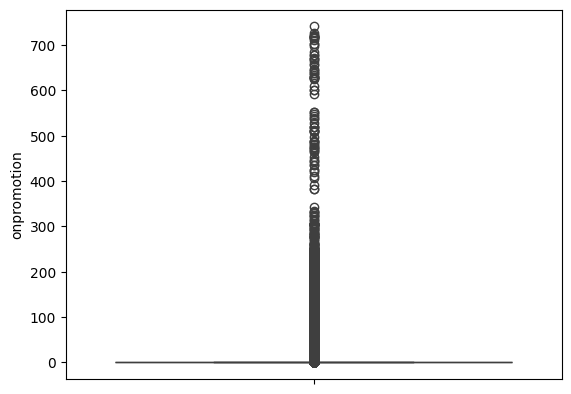

In [45]:
sns.boxplot(data=train_df['onpromotion'])
plt.xticks(rotation=90)
plt.show()


Seasonality detection using heatmap¶



Weekly seasonality¶


<Axes: title={'center': 'Sales by Day of Week and Month'}, xlabel='month', ylabel='day_of_week'>

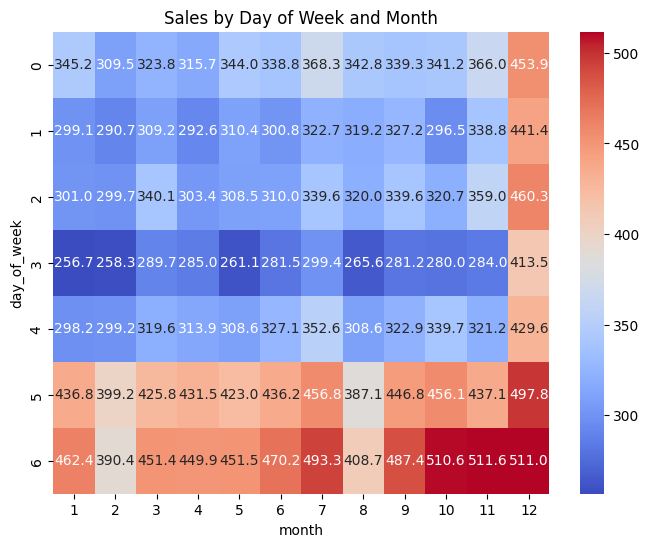

In [46]:
plt.figure(figsize=(8,6))
plt.title('Sales by Day of Week and Month')
sns.heatmap(train_df.pivot_table(index='day_of_week', columns='month', values='sales', aggfunc='mean'), annot=True, fmt='.1f', cmap='coolwarm')


Monthly Patterns Across Years¶


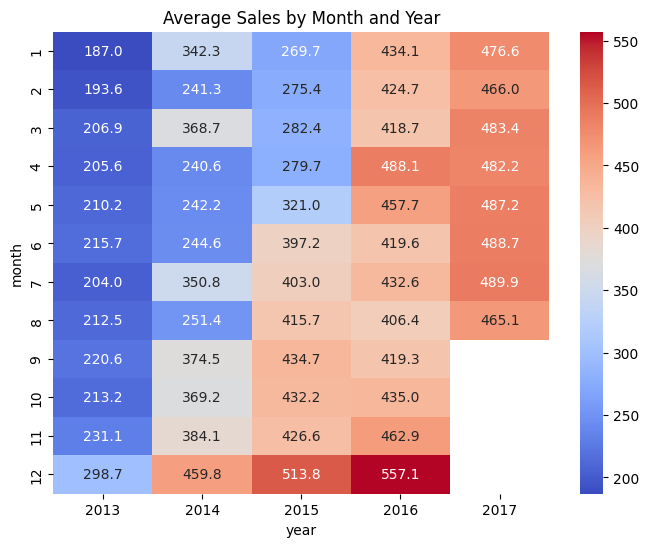

In [47]:
plt.figure(figsize=(8, 6))
plt.title('Average Sales by Month and Year')
sns.heatmap(train_df.pivot_table(index='month', columns='year',values='sales', aggfunc='mean'), cmap='coolwarm', annot=True, fmt='.1f')
plt.show()


Corelation Matrix¶


<Axes: >

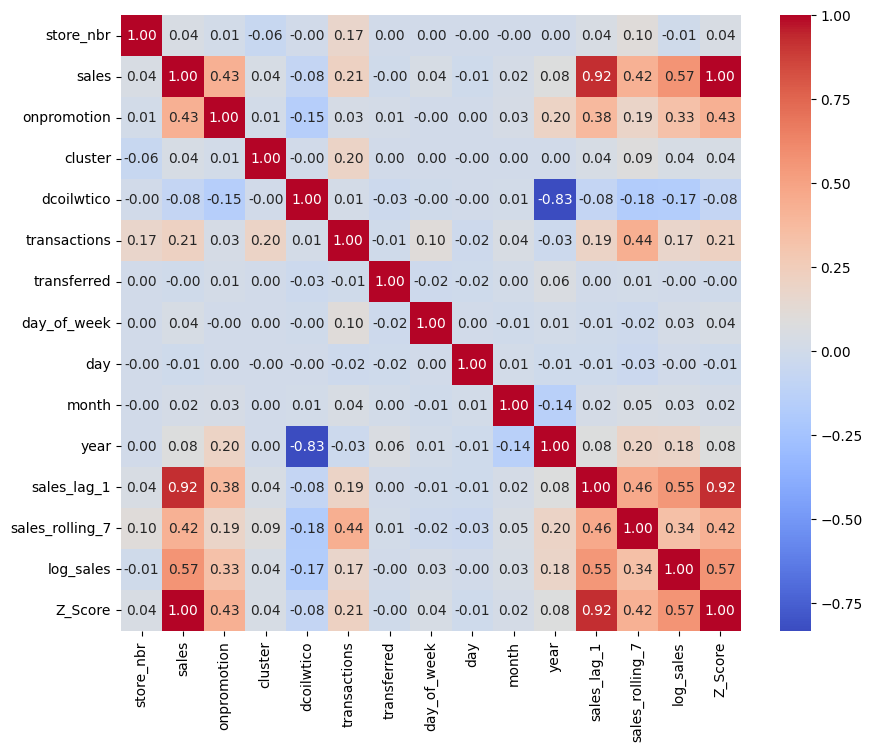

In [48]:
heat_df = train_df.drop('id', axis = 1)
plt.figure(figsize=(10, 8))
sns.heatmap(heat_df.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm')


#### Seasonality check

In [30]:
daily_sales = train_df.groupby('date')['sales'].sum()
weekly_sales = daily_sales.resample('W').sum()
monthly_sales = daily_sales.resample('ME').sum()
yearly_sales = daily_sales.resample('YE').sum()

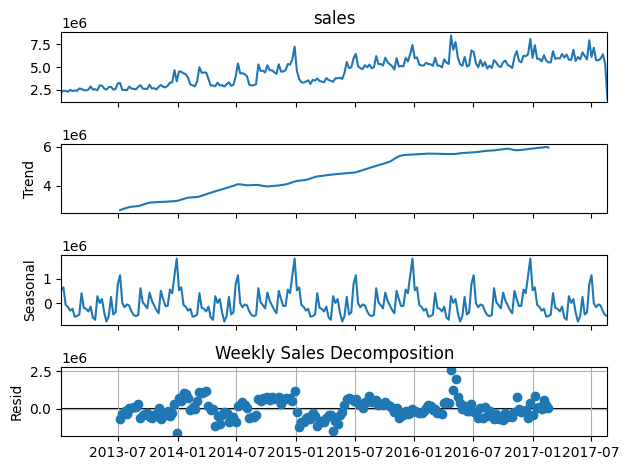

In [50]:
result = seasonal_decompose(weekly_sales, model='additive')
result.plot()
plt.title('Weekly Sales Decomposition')
plt.tight_layout()
plt.grid(True)
plt.show()

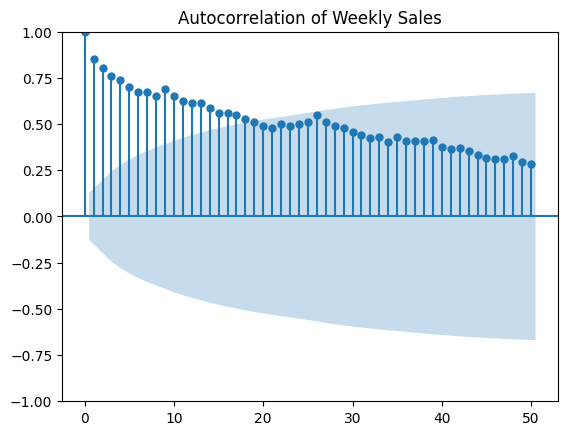

In [51]:
plot_acf(weekly_sales, lags = 50)
plt.title("Autocorrelation of Weekly Sales")
plt.show()

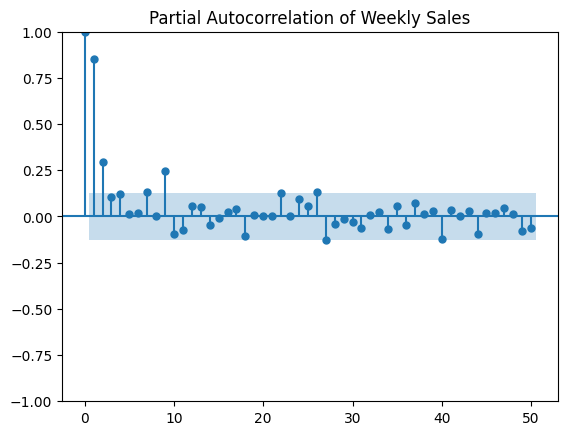

In [52]:
plot_pacf(weekly_sales, lags = 50)
plt.title('Partial Autocorrelation of Weekly Sales')
plt.show()


Periodogram (Fourier Transform for Frequency Detection)¶


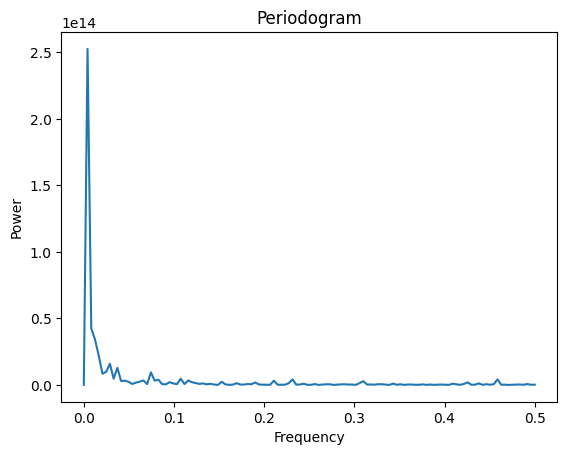

In [53]:
freqs, psd = periodogram(weekly_sales)
plt.plot(freqs, psd)
plt.title('Periodogram')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.show()

>### Time Series forecasting

In [31]:
n = 3
lr_store = train_df['store_nbr'].nlargest(n)
lr_store

lr_des = train_df['family'].value_counts().nlargest(n).index.tolist()
lr_des

['AUTOMOTIVE', 'BABY CARE', 'BEAUTY']

In [33]:
train_df_encoded = pd.get_dummies(train_df, columns= ['family', 'state', 'type_holiday'], drop_first=True)

In [23]:
train_df['family'].nunique()

33

In [21]:
train_df.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'type_train', 'cluster', 'dcoilwtico', 'transactions',
       'type_holiday', 'locale', 'locale_name', 'description', 'transferred',
       'day_of_week', 'day', 'month', 'year', 'sales_lag_1', 'sales_rolling_7',
       'Z_Score'],
      dtype='object')

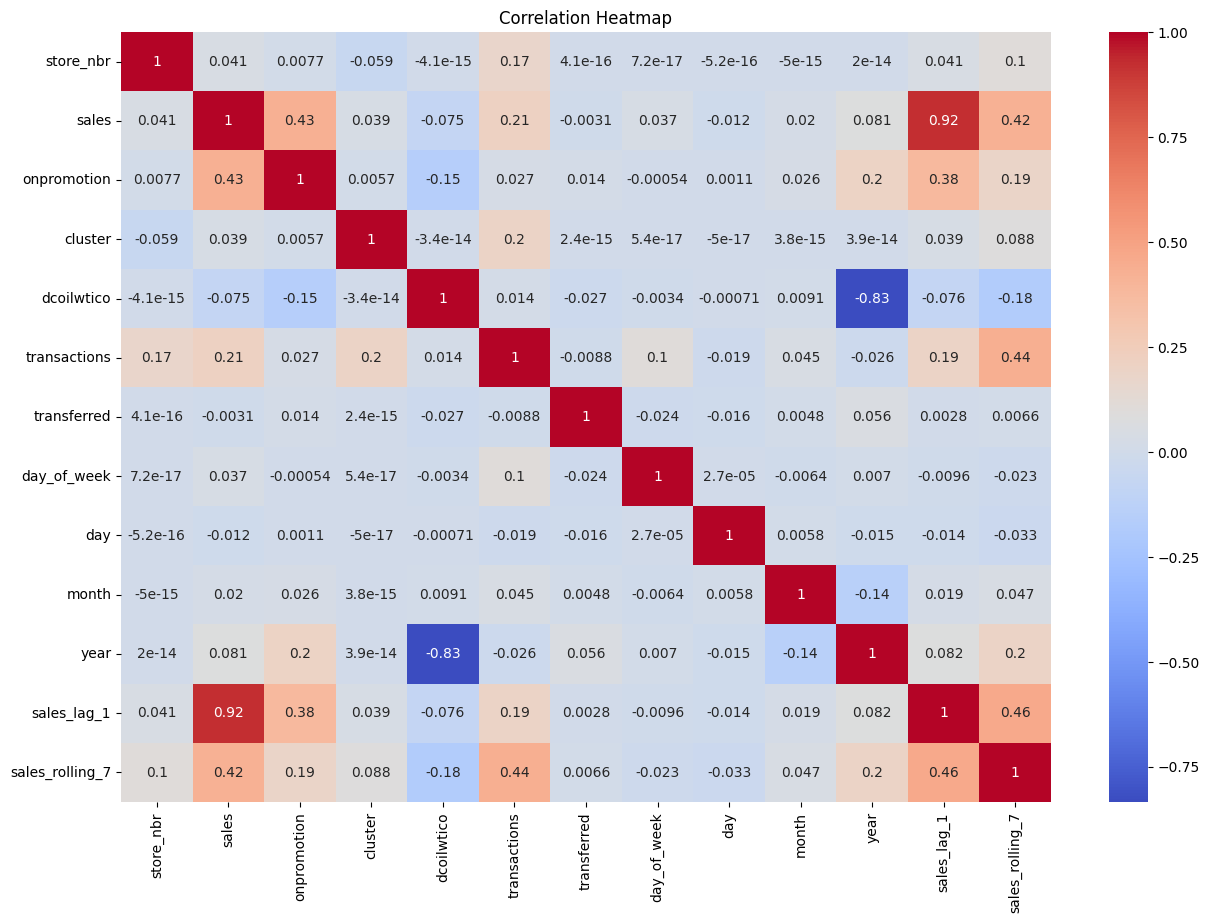

In [68]:
plt.figure(figsize=(15,10))
sns.heatmap(train_df[['date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'type_train', 'cluster', 'dcoilwtico', 'transactions',
       'type_holiday', 'locale', 'locale_name', 'description', 'transferred',
       'day_of_week', 'day', 'month', 'year', 'sales_lag_1', 'sales_rolling_7']].corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

#### Saving data to .csv

In [34]:
df_ml = train_df_encoded.copy()

scaler = StandardScaler()
df_ml['sales_scaled'] = scaler.fit_transform(df_ml['sales'].values.reshape(-1, 1))

In [35]:
# Data for ML model
# Have encoded + scaled sales values
df_ml.to_csv("df_ml.csv",index=False)

In [ ]:
train_df = train_df.drop('Z_Score', axis = 1)

In [37]:
# cleaned train_df 

train_df.to_csv("train_df_cleaned.csv", index=False)

>### Pipeline

#### Importing train_df cleaned dataset

In [2]:
df = pd.read_csv("train_df_cleaned.csv")

>### Pipeline for XG & RF

In [3]:
# Define columns
cat_features = ['family', 'type_holiday']
num_features = ['store_nbr', 'onpromotion', 'dcoilwtico', 'transactions', 'cluster', 'sales_lag_1', 'sales_rolling_7', 'day', 'month', 'year']

selected_families = ['AUTOMOTIVE', 'BEAUTY']
xg_df = df[(df['store_nbr'] == 54) & (df['family'].isin(selected_families))]

X_features = xg_df[cat_features + num_features]
Y = xg_df['sales']

# Define transformers
cat_transformer = OneHotEncoder(handle_unknown= 'ignore', drop='first')
num_transformer = StandardScaler()

# Combine
preprocessor = ColumnTransformer([
    ('cat', cat_transformer, cat_features),
    ('num', num_transformer, num_features)
])

# Example pipeline
pipeline_xg = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6))  
])

pipeline_rf = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100))  
])

param_grid_rf = {
    'model__min_samples_split' : [2,4],
    'model__min_samples_leaf' : [1,2],
    'model__n_estimators' : [100, 200],
    'model__max_depth' : [3,5]
}

grid_search_rf = GridSearchCV(
    estimator=  pipeline_rf,
    param_grid= param_grid_rf, 
    verbose= 2,
    n_jobs = -1,
    cv = 3,
    scoring  = 'neg_mean_squared_error'
)

param_grid_xg = {
    'model__colsample_bytree' : [0.8, 1.0],
    'model__learning_rate' : [0.05, 0.1],
    'model__n_estimators' : [100, 250],
    'model__max_depth' : [3,5]
}

grid_search_xg = GridSearchCV(
    estimator=  pipeline_xg,
    param_grid= param_grid_xg, 
    verbose= 2,
    n_jobs = -1,
    cv = 3,
    scoring  = 'neg_mean_squared_error'
)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_features, Y, test_size=0.1)

In [5]:
X_test.to_csv("X_test.csv", index=False)

#### RF Model

In [13]:
rf_model = grid_search_rf.fit(X_train, y_train)
rf_model

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['family',
                                                                          'type_holiday']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['store_nbr',
                                                                          'onpromotion',
                                                                          'dcoilwtico',
                                                                          'transactions',
                                                                          'cluster',
                                                                          'sales_lag_1',
                                                                          'sales_rolling_7',
                                                                          'day',
                                                                          'month',
                                                                          'year'])])),
                                       ('model', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'model__max_depth': [3, 5],
                         'model__min_samples_leaf': [1, 2],
                         'model__min_samples_split': [2, 4],
                         'model__n_estimators': [100, 200]},
             scoring='neg_mean_squared_error', verbose=2)

In [15]:
best_rf_pipeline = grid_search_rf.best_estimator_
best_rf_model = best_rf_pipeline.named_steps['model']
y_pred_rf = rf_model.predict(X_test)

#### XGBoost 

In [16]:
xg_model = grid_search_xg.fit(X_train, y_train)
xg_model

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['family',
                                                                          'type_holiday']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['store_nbr',
                                                                          'onpromotion',
                                                                          'dcoilwtico',
                                                                          'transactions',
                                                                          'cluster',
                                                                          'sales_lag_1',
                                                                          'sales_rolling_7',
                                                                          'day',
                                                                          'month',
                                                                          'year'])])),
                                       ('model',
                                        XGBRegressor(ba...
                                                     max_depth=6,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.8, 1.0],
                         'model__learning_rate': [0.05, 0.1],
                         'model__max_depth': [3, 5],
                         'model__n_estimators': [100, 250]},
             scoring='neg_mean_squared_error', verbose=2)

In [17]:
best_xg_pipeline = grid_search_xg.best_estimator_
best_xg_model = best_xg_pipeline.named_steps['model']
y_pred_xg = xg_model.predict(X_test)

In [168]:
xg_df.to_csv("xg_df.csv", index=False)

In [59]:
joblib.dump(xg_model,"XGBR_model.pkl")
joblib.dump(rf_model, "RF_model.pkl")

['RF_model.pkl']

>### ARIMA/ SARIMA Model

#### Selecting a store item for forecasting

In [17]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
combo_df = df[(df['store_nbr'] == 54) & (df['family'] == 'AUTOMOTIVE')]
combo_df = combo_df.set_index('date').resample('D').sum().fillna(0)

# combo_df['sales'] = np.log1p(combo_df['sales'])
# combo_df['sales'] = np.expm1(combo_df['sales'])

#### ADF

In [19]:
result_adf = adfuller(combo_df['sales'])
print("ADF Statistic: ", result_adf[0])
print("p-values: ", result_adf[1])

ADF Statistic:  -4.321682280949174
p-values:  0.00040733651058590874


<Figure size 1000x400 with 0 Axes>

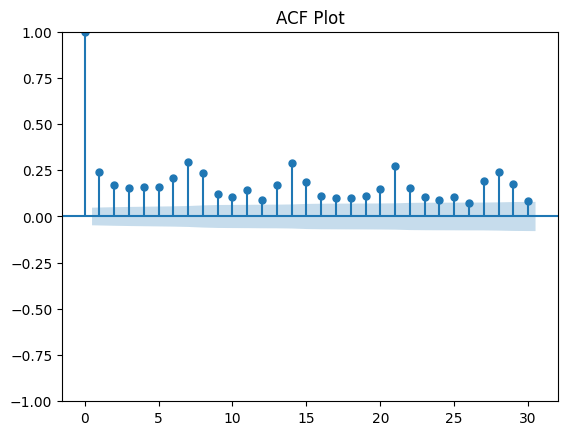

<Figure size 1000x400 with 0 Axes>

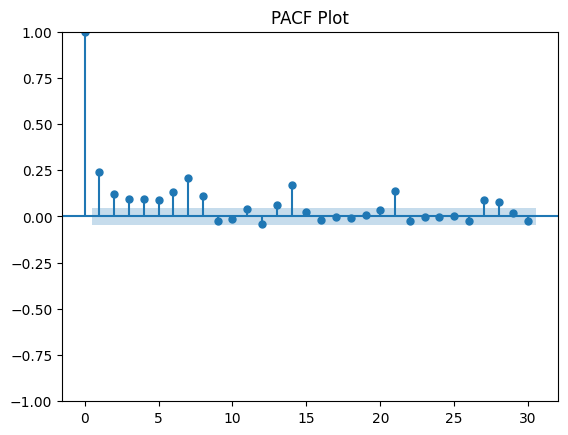

In [20]:
plt.figure(figsize=(10,4))
plot_acf(combo_df['sales'], lags=30)
plt.title("ACF Plot")
plt.show()

plt.figure(figsize=(10,4))
plot_pacf(combo_df['sales'], lags=30)
plt.title("PACF Plot")
plt.show()


In [21]:
model = SARIMAX(combo_df['sales'],
                order=(1, 0, 2),
                seasonal_order=(1, 0, 2, 7),
                exog=combo_df[['sales_rolling_7']],
                enforce_stationarity=False,
                enforce_invertibility=False
                )  # optional

results = model.fit(disp=False, maxiter=1000)
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             sales   No. Observations:                 1688
Model:             SARIMAX(1, 0, 2)x(1, 0, 2, 7)   Log Likelihood               -4278.053
Date:                           Fri, 13 Jun 2025   AIC                           8572.107
Time:                                   16:02:07   BIC                           8615.476
Sample:                               01-01-2013   HQIC                          8588.176
                                    - 08-15-2017                                         
Covariance Type:                             opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
sales_rolling_7     0.0073      0.000     23.798      0.000       0.007       0.008
ar.L1               0.8746  

| Metric                          | Value                                                                                      | Analysis                                             |
| ------------------------------- | ------------------------------------------------------------------------------------------ | ---------------------------------------------------- |
| **MAE**                         | `2.27`                                                                                     | Low → Good accuracy                                  |
| **RMSE**                        | `2.76`                                                                                     | Low error overall                                    |
| **Naive MAE**                   | `3.72`                                                                                     | Model outperforms the naive baseline clearly ✅  |
| **AIC**                         | `8572.8`                                                                                   | Use for comparing with other models (lower = better) |
| **Significant Coefficients**    | All P-values < 0.05                                                                        | ✅ All model terms including `onpromotion` are useful |
| **ar.S.L7 = 0.9995**            | Seasonal (weekly) dependence is very strong                                                |                                                      |
| **Residual Diagnostics**        | JB Test: `p = 0.00` → residuals not normally distributed (may improve with transformation) |                                                      |
| **Ljung-Box Q Test (p = 0.71)** | ✅ No autocorrelation in residuals                                                          |                                                      |


### Forecast

In [22]:
train = combo_df.iloc[:-30]
test = combo_df.iloc[-30:]

model = SARIMAX(train['sales'],
                order=(1, 0, 1),
                seasonal_order=(1, 0, 1, 7),
                exog=train[['sales_rolling_7']])
results = model.fit()

forecast = results.get_prediction(start=test.index[0],
                           end=test.index[-1],
                           exog=test[['sales_rolling_7']])
# forecast = np.expm1(forecast)

c:\Users\M Khubaib Ahmad\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\M Khubaib Ahmad\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


##### Saving Model

In [58]:
joblib.dump(results, "SARIMAX_model.pkl")

['SARIMAX_model.pkl']

In [24]:
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

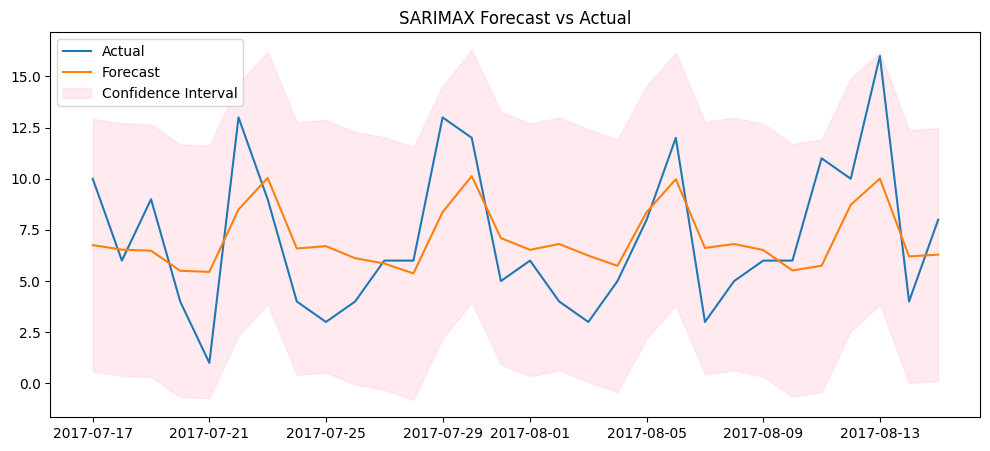

In [25]:
plt.figure(figsize=(12, 5))
# plt.plot(train.index, train['sales'], label='Train')
plt.plot(test.index, test['sales'], label='Actual')
plt.plot(test.index, forecast_mean, label='Forecast')
plt.fill_between(test.index, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], 
                 color='pink', alpha=0.3, label='Confidence Interval')
plt.legend()
plt.title("SARIMAX Forecast vs Actual")
plt.show()

#### Forecating Plot

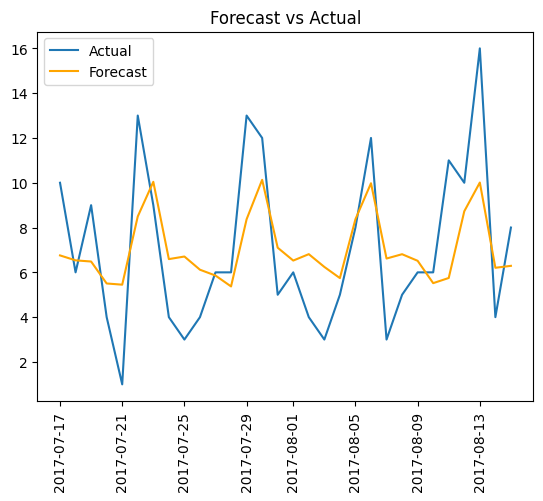

In [26]:
plt.plot(test.index, test['sales'], label='Actual')
plt.plot(test.index, forecast_mean, label='Forecast', color='orange')
plt.title("Forecast vs Actual")
plt.xticks(rotation=90)
plt.legend()
plt.show()

>### Evaluation of models by RMSE, MAE, and R2 Score

In [57]:
mae_rf = mean_absolute_error(y_test, y_pred_xg)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_xg))

print(f"MAE(RF):   {mae_rf:.2f}")
print(f"RMSE(RF):  {rmse_rf:.2f}")
score_rf = r2_score(y_test,y_pred_rf)
print(f"R2_score(RF): {score_rf:.2f}")

mae_xg = mean_absolute_error(y_test, y_pred_rf)
rmse_xg = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(f"\nMAE(XG):   {mae_xg:.2f}")
print(f"RMSE(XG):  {rmse_xg:.2f}")
score_xg = r2_score(y_test,y_pred_xg)
print(f"R2_score(RF): {score_xg:.2f}")

MAE(RF):   1.48
RMSE(RF):  2.14
R2_score(RF): 0.68

MAE(XG):   1.42
RMSE(XG):  2.06
R2_score(RF): 0.66


In [28]:
mae_sarimax = mean_absolute_error(test['sales'], forecast_mean)
rmse_sarimax = np.sqrt(mean_squared_error(test['sales'], forecast_mean))

print(f'\nMAE(SARIMAX):  {mae_sarimax:.2f}\nRMSE(SARIMAX): {rmse_sarimax:.2f}')


MAE(SARIMAX):  2.27
RMSE(SARIMAX): 2.76


>#### Evaluate the models using SHAP values

C:\Users\M Khubaib Ahmad\AppData\Local\Temp\ipykernel_24424\3679790274.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_rf, X_transformed_rf)


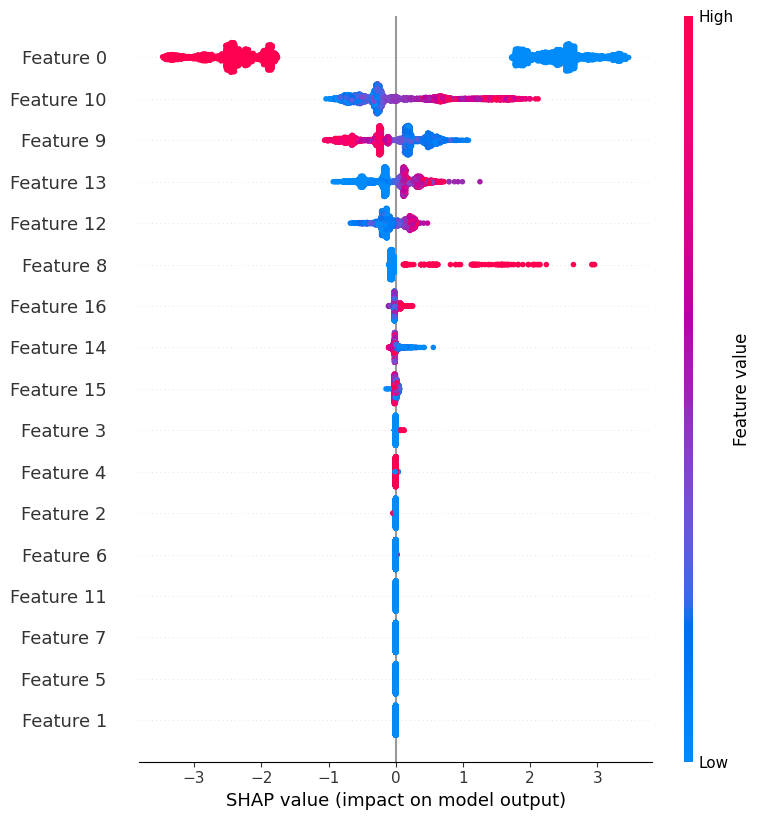

In [19]:
X_test = pd.read_csv("X_test.csv")

# Load the trained models
rf_model = joblib.load("RF_model.pkl")
# xg_model = joblib.load("XGBR_model.pkl")

X_transformed_rf = best_rf_pipeline.named_steps['preprocessing'].transform(X_features)
X_transformed_xg = best_xg_pipeline.named_steps['preprocessing'].transform(X_features)

explainer_rf = shap.TreeExplainer(best_rf_model)
shap_values_rf = explainer_rf.shap_values(X_transformed_rf)

# Plot
shap.summary_plot(shap_values_rf, X_transformed_rf)

C:\Users\M Khubaib Ahmad\AppData\Local\Temp\ipykernel_24424\908433029.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_xg, X_transformed_xg)


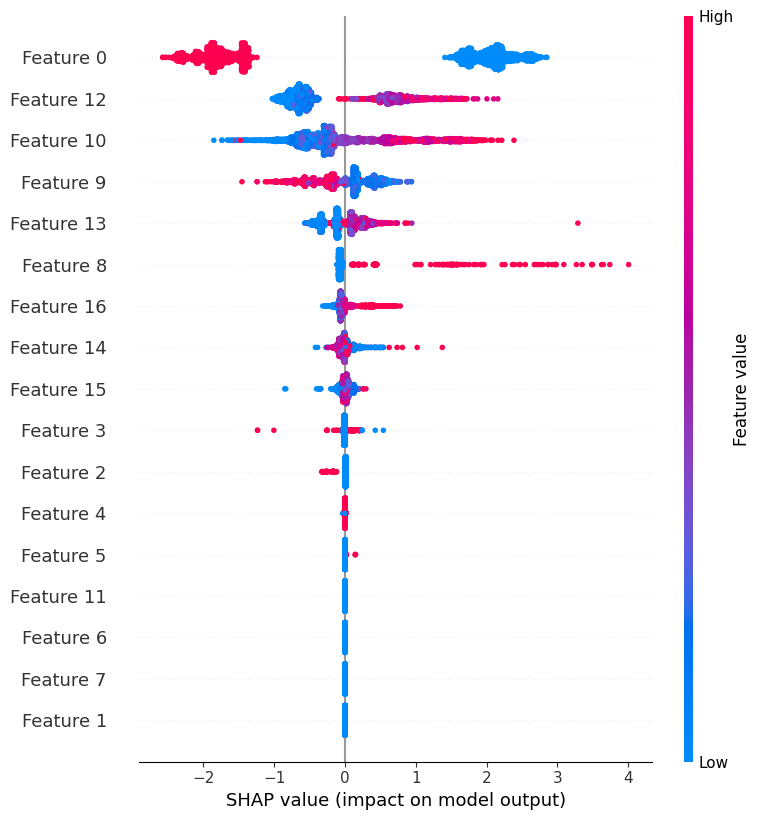

In [20]:
explainer_xg = shap.TreeExplainer(best_xg_model)
shap_values_xg = explainer_xg.shap_values(X_transformed_xg)

# Plot
shap.summary_plot(shap_values_xg, X_transformed_xg)

In [22]:
cat_encoded_names = best_rf_pipeline.named_steps['preprocessing'].named_transformers_['cat'].get_feature_names_out(cat_features)
all_feature_names = np.concatenate([cat_encoded_names, num_features])
all_feature_names

array(['family_BEAUTY', 'type_holiday_Bridge', 'type_holiday_Event',
       'type_holiday_Holiday', 'type_holiday_No Holiday',
       'type_holiday_Transfer', 'type_holiday_Work Day', 'store_nbr',
       'onpromotion', 'dcoilwtico', 'transactions', 'cluster',
       'sales_lag_1', 'sales_rolling_7', 'day', 'month', 'year'],
      dtype=object)

#### Evaluation of RF by SHAP

C:\Users\M Khubaib Ahmad\AppData\Local\Temp\ipykernel_24424\2665738659.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_rf, pd.DataFrame(X_transformed_rf, columns=all_feature_names))


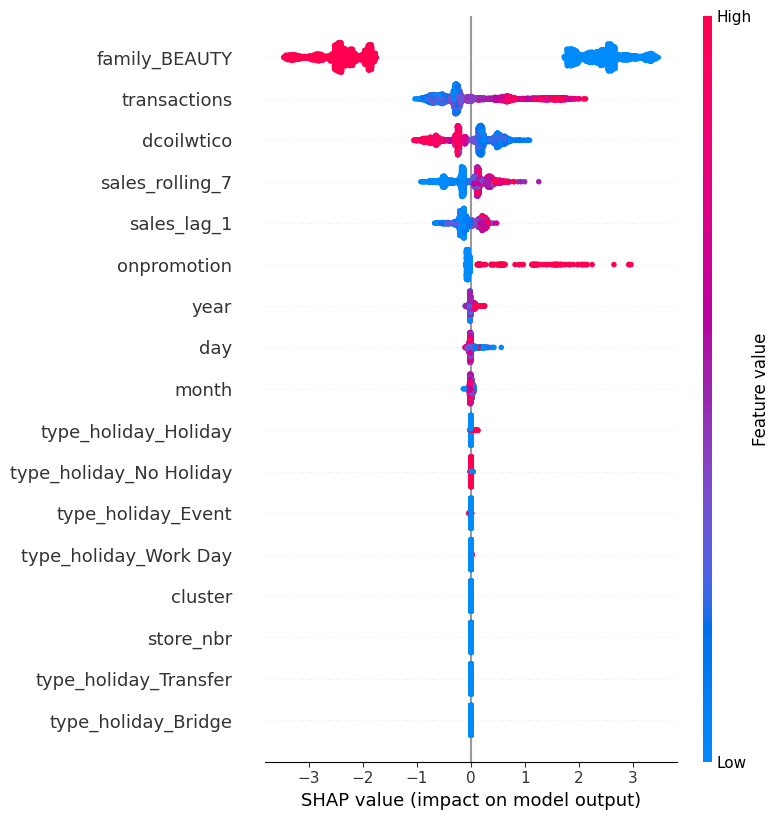

In [23]:
shap.summary_plot(shap_values_rf, pd.DataFrame(X_transformed_rf, columns=all_feature_names))

#### Evaluation of XG by SHAP

C:\Users\M Khubaib Ahmad\AppData\Local\Temp\ipykernel_24424\162861694.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_rf, pd.DataFrame(X_transformed_xg, columns=all_feature_names))


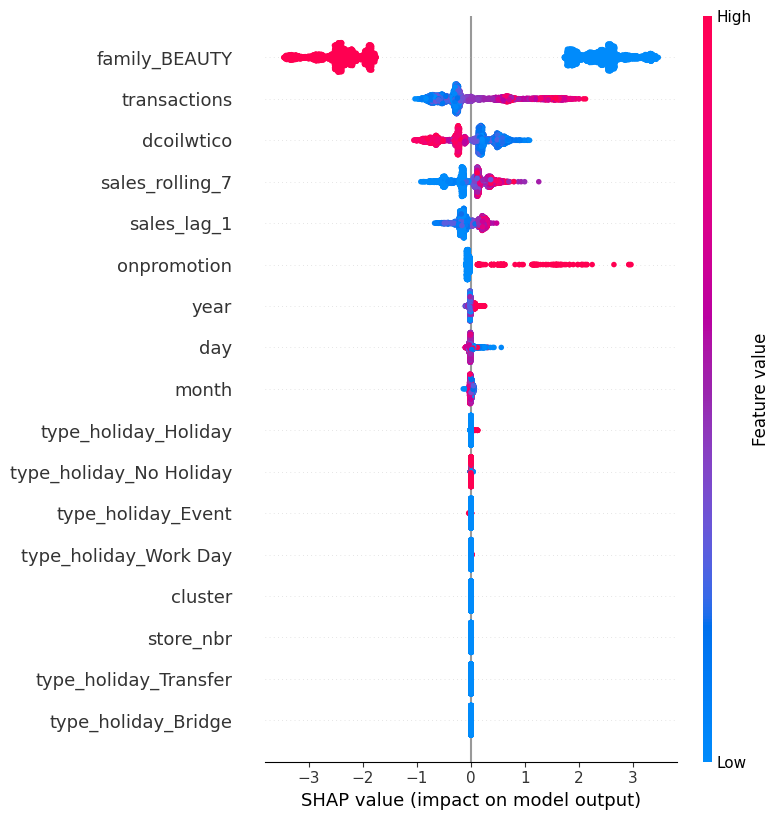

In [24]:
shap.summary_plot(shap_values_rf, pd.DataFrame(X_transformed_xg, columns=all_feature_names))

##### Comparison of SARIMAX With Naive Forecast

In [154]:
naive_forecast = test['sales'].shift(1)
# naive_forecast = np.expm1(naive_forecast)
naive_mae = mean_absolute_error(test['sales'][1:], naive_forecast[1:])
print(f"Naive MAE: {naive_mae:.2f}")

Naive MAE: 3.72


>### 7 days sales forecast by SARIMAX

In [ ]:
custom_sarima_data = {
    'sales_rolling_7': [42.1, 43.2, 44.0, 45.3, 46.1, 47.5, 48.0]
}
custom_index = pd.date_range(start='2017-08-16', periods=7, freq='D')
custom_df = pd.DataFrame(custom_sarima_data, index=custom_index)

forecast_cus = results.get_forecast(
    # start=custom_df.index[0],  
    # end=custom_df.index[-1],
    steps=7,  # Forecast for the next 7 days
    exog=custom_df[['sales_rolling_7']]
)

# Get predicted values
predicted_values = forecast_cus.predicted_mean
print(predicted_values)

2017-07-17    3.853103
2017-07-18    4.773580
2017-07-19    4.994744
2017-07-20    2.781548
2017-07-21    4.222183
2017-07-22    6.349951
2017-07-23    7.648653
Freq: D, Name: predicted_mean, dtype: float64


>### Predictions on custom data by RF & XG

In [81]:
sample_data = pd.DataFrame({
    'family': ['AUTOMOTIVE'],            # categorical
    'type_holiday': ['None'],        # categorical
    'store_nbr': [54],               # numeric
    'onpromotion': [12],             # numeric
    'dcoilwtico': [65.32],           # numeric (oil price)
    'transactions': [1789.0],        # numeric
    'cluster': [7],                  # numeric
    'sales_lag_1': [230.4],          # numeric
    'sales_rolling_7': [215.7],      # numeric
    'day': [23],                     # numeric
    'month': [7],                    # numeric
    'year': [2017]                   # numeric
})

#### XGBoost prediction

In [82]:
print("Prediction: ",xg_model.predict(sample_data))

Prediction:  [10.173132]


c:\Users\M Khubaib Ahmad\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


#### RF prediction

In [83]:
print(rf_model.predict(sample_data))

[7.31629427]


c:\Users\M Khubaib Ahmad\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
